# Import library

In [1]:
import torch 
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET



# Dataset & Dataloader 
## Build vocab


In [2]:
input_files = ['crohme2019_train.txt', 'crohme2019_test.txt', 'crohme2019_valid.txt']

In [3]:
vocab = set()
for input_file in input_files:
    for line in open(input_file).readlines():
        if len(line.strip().split('\t')) == 2:
            vocab.update(line.strip().split('\t')[1].split())

In [4]:
vocab_syms = [v for v in vocab if v not in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']]

In [5]:
with open('crohme_vocab.txt', 'w') as f:
    f.writelines([c + '\n' for c in sorted(vocab_syms)])
    f.writelines([c + '\n' for c in ['Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']])

In [6]:
class Vocab(object):
    def __init__(self, vocab_file=None):
        self.word2index = {}
        self.index2word = {}

        if vocab_file:
            self.load_vocab(vocab_file)
    
    def load_vocab(self, vocab_file):
        # load vocab from file
        with open(vocab_file, 'r') as f:
            for i, line in enumerate(f):
                word = line.strip()
                self.word2index[word] = i
                self.index2word[i] = word
        # add blank word
        self.word2index['<blank>'] = len(self.word2index)
        self.index2word[self.word2index['<blank>']] = '<blank>'

In [7]:
vocab = Vocab('crohme_vocab.txt')
input = 'f Sup \prime NoRel ( Right x Right ) Right = NoRel 1 NoRel - Below 2 Right \sqrt Inside x'.split()
output = [vocab.word2index[word] for word in input]
print(output)

[79, 107, 62, 104, 1, 105, 97, 105, 2, 105, 17, 104, 8, 104, 4, 102, 9, 105, 66, 103, 97]


In [8]:
vocab.word2index

{'!': 0,
 '(': 1,
 ')': 2,
 '+': 3,
 '-': 4,
 '.': 5,
 '/': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 '=': 17,
 'A': 18,
 'B': 19,
 'C': 20,
 'COMMA': 21,
 'E': 22,
 'F': 23,
 'G': 24,
 'H': 25,
 'I': 26,
 'L': 27,
 'M': 28,
 'N': 29,
 'P': 30,
 'R': 31,
 'S': 32,
 'T': 33,
 'V': 34,
 'X': 35,
 'Y': 36,
 '[': 37,
 '\\Delta': 38,
 '\\alpha': 39,
 '\\beta': 40,
 '\\cos': 41,
 '\\div': 42,
 '\\exists': 43,
 '\\forall': 44,
 '\\gamma': 45,
 '\\geq': 46,
 '\\gt': 47,
 '\\in': 48,
 '\\infty': 49,
 '\\int': 50,
 '\\lambda': 51,
 '\\ldots': 52,
 '\\leq': 53,
 '\\lim': 54,
 '\\log': 55,
 '\\lt': 56,
 '\\mu': 57,
 '\\neq': 58,
 '\\phi': 59,
 '\\pi': 60,
 '\\pm': 61,
 '\\prime': 62,
 '\\rightarrow': 63,
 '\\sigma': 64,
 '\\sin': 65,
 '\\sqrt': 66,
 '\\sum': 67,
 '\\tan': 68,
 '\\theta': 69,
 '\\times': 70,
 '\\{': 71,
 '\\}': 72,
 ']': 73,
 'a': 74,
 'b': 75,
 'c': 76,
 'd': 77,
 'e': 78,
 'f': 79,
 'g': 80,
 'h': 81,
 'i': 82,
 'j': 83,


In [9]:
vocab.index2word

{0: '!',
 1: '(',
 2: ')',
 3: '+',
 4: '-',
 5: '.',
 6: '/',
 7: '0',
 8: '1',
 9: '2',
 10: '3',
 11: '4',
 12: '5',
 13: '6',
 14: '7',
 15: '8',
 16: '9',
 17: '=',
 18: 'A',
 19: 'B',
 20: 'C',
 21: 'COMMA',
 22: 'E',
 23: 'F',
 24: 'G',
 25: 'H',
 26: 'I',
 27: 'L',
 28: 'M',
 29: 'N',
 30: 'P',
 31: 'R',
 32: 'S',
 33: 'T',
 34: 'V',
 35: 'X',
 36: 'Y',
 37: '[',
 38: '\\Delta',
 39: '\\alpha',
 40: '\\beta',
 41: '\\cos',
 42: '\\div',
 43: '\\exists',
 44: '\\forall',
 45: '\\gamma',
 46: '\\geq',
 47: '\\gt',
 48: '\\in',
 49: '\\infty',
 50: '\\int',
 51: '\\lambda',
 52: '\\ldots',
 53: '\\leq',
 54: '\\lim',
 55: '\\log',
 56: '\\lt',
 57: '\\mu',
 58: '\\neq',
 59: '\\phi',
 60: '\\pi',
 61: '\\pm',
 62: '\\prime',
 63: '\\rightarrow',
 64: '\\sigma',
 65: '\\sin',
 66: '\\sqrt',
 67: '\\sum',
 68: '\\tan',
 69: '\\theta',
 70: '\\times',
 71: '\\{',
 72: '\\}',
 73: ']',
 74: 'a',
 75: 'b',
 76: 'c',
 77: 'd',
 78: 'e',
 79: 'f',
 80: 'g',
 81: 'h',
 82: 'i',
 83: 'j',


## Write dataset class

In [10]:

class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""
    __slots__ = ('id', 'label' ,'strId')
    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])

class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""
    __slots__ = ('fileName', 'strokes', 'strkOrder','segments','truth','UI')

    NS = {'ns': 'http://www.w3.org/2003/InkML', 'xml': 'http://www.w3.org/XML/1998/namespace'}

    def __init__(self,*args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()
    
    def fixNS(self,ns,att):
        """Build the right tag or element name with namespace"""
        return '{'+Inkml.NS[ns]+'}'+att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall('ns:annotation',namespaces=Inkml.NS):
            if 'type' in info.attrib:
                if info.attrib['type'] == 'truth':
                    self.truth = info.text.strip()
                if info.attrib['type'] == 'UI':
                    self.UI = info.text.strip()
        for strk in root.findall('ns:trace',namespaces=Inkml.NS):
            self.strokes[strk.attrib['id']] = strk.text.strip()
            self.strkOrder.append(strk.attrib['id'])
        segments = root.find('ns:traceGroup',namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in (segments.iterfind('ns:traceGroup',namespaces=Inkml.NS)):
            id = seg.attrib[self.fixNS('xml','id')]
            label = seg.find('ns:annotation',namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall('ns:traceView',namespaces=Inkml.NS):
                strkList.add(t.attrib['traceDataRef'])
            self.segments[id] = Segment(id,label, strkList)
        
    def getTraces(self, height = 256):
        traces_array = [np.array([p.strip().split()[:2]
            for p in self.strokes[id].split(',')], dtype='float') 
              for id in self.strkOrder ]
        
        ratio = height / ((np.concatenate(traces_array, 0).max(0) - np.concatenate(traces_array, 0).min(0))[1] + 1e-6)
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

In [11]:
ink = Inkml(r'crohme2019\crohme2019\train/MfrDB2372.inkml')
print([np.array(trace).shape for trace in ink.getTraces()])

[(1, 2), (81, 2), (7, 2), (22, 2), (11, 2), (17, 2), (16, 2), (8, 2), (11, 2), (37, 2), (20, 2), (31, 2), (1, 2), (76, 2), (10, 2), (15, 2)]


In [12]:
for trace in ink.getTraces():
    print(trace)

[[612, 277]]
[[417, 314], [418, 314], [422, 307], [425, 298], [430, 285], [442, 258], [449, 238], [451, 228], [453, 225], [453, 212], [451, 204], [448, 200], [445, 200], [442, 204], [438, 211], [436, 213], [435, 214], [431, 222], [431, 227], [431, 233], [431, 237], [430, 251], [424, 290], [424, 310], [423, 324], [422, 332], [422, 336], [422, 337], [419, 342], [417, 346], [415, 356], [412, 371], [412, 377], [412, 385], [412, 392], [412, 395], [414, 394], [417, 389], [424, 372], [430, 358], [432, 351], [434, 348], [434, 345], [434, 343], [434, 340], [434, 338], [432, 336], [432, 333], [431, 333], [431, 332], [431, 331], [429, 323], [427, 317], [424, 314], [423, 313], [423, 312], [422, 311], [421, 311], [419, 311], [417, 311], [416, 311], [415, 311], [414, 311], [412, 311], [410, 311], [416, 311], [421, 311], [425, 311], [427, 311], [429, 310], [431, 307], [432, 307], [443, 297], [444, 297], [445, 296], [451, 291], [463, 276], [468, 270], [469, 266], [470, 265], [470, 264]]
[[476, 169], [

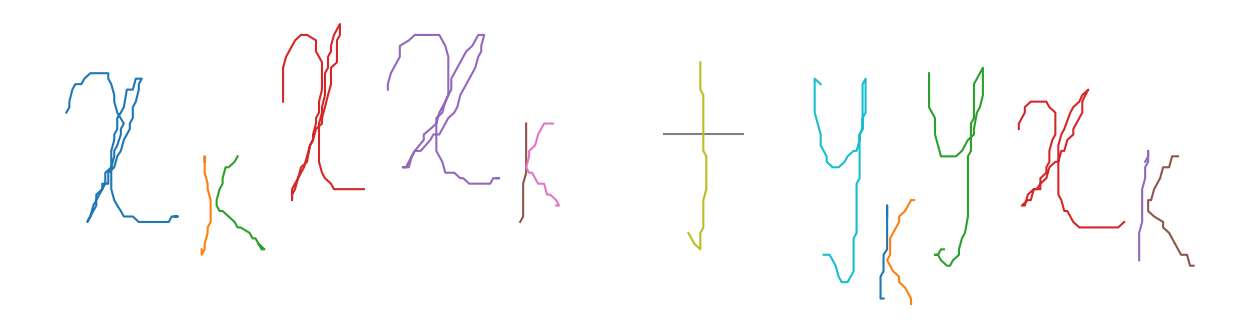

In [13]:

def visualize_inkml(ink_obj: Inkml):
    ink = ink_obj

    plt.figure(figsize=(16, 4))
    plt.axis("off")
    for trace in ink.getTraces():
        trace_arr = np.array(trace)
        plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate
path = r'crohme2019/crohme2019/valid/18_em_0.inkml'
ink = Inkml(path)
visualize_inkml(ink)

In [14]:
def remove_duplicate(trace):
    # your implementation to remove consecutive duplicated points
    new_trace = []
    for point in trace: 
        if not new_trace or point != new_trace[-1]:
            new_trace.append(point)
    return new_trace

In [15]:
ink = Inkml(r'crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]

assert list(map(len,traces)) == [82, 16, 21, 78, 82, 15, 18, 18, 28, 58, 15, 19, 56, 70, 18, 21], "Error: traces not correctly loaded"
print("Passed")

Passed


In [16]:
def find_stroke_ends(traces):
    stroke_lengths = np.array([len(stroke) for stroke in traces])
    end_indices = np.cumsum(stroke_lengths) - 1
    return end_indices
def feature_extraction (traces):
    # your implementation
    points = np.vstack(traces)
    deltas = np.diff(points, axis = 0)
    distances = np.linalg.norm(deltas, axis = 1).reshape(-1, 1)
    epsilon = 1e-10
    distances += epsilon
    normalized_delta = deltas / distances
    features = np.hstack((normalized_delta, distances))
    return features

In [17]:
ink = Inkml(r'crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 3)
npt.assert_allclose(feature.mean(axis=0), np.array([ 0.17677799,  0.29519369, 11.35540311]))
npt.assert_allclose(feature.var(axis=0), np.array([3.75390418e-01, 5.06219812e-01, 4.19017361e+02])
)
print("Passed")

Passed


In [18]:
def find_stroke_ends(traces):
    stroke_lengths = np.array([len(stroke) for stroke in traces])
    end_indices = np.cumsum(stroke_lengths) - 1
    return end_indices
# def feature_extraction (traces):
#     # your implementation
#     points = np.vstack(traces)
#     deltas = np.diff(points, axis = 0)
#     distances = np.linalg.norm(deltas, axis = 1).reshape(-1, 1)
#     normalized_delta = deltas / distances
#     features = np.hstack((normalized_delta, distances))
#     indices = find_stroke_ends(traces)
#     pen_up = np.zeros((features.shape[0], 1))
#     pen_up_indices = indices[:-1]
#     pen_up[pen_up_indices] = 1
#     features = np.hstack((features, pen_up))
#     return features
def feature_extraction(traces):
    points = np.vstack(traces)
    deltas = np.diff(points, axis=0)
    distances = np.linalg.norm(deltas, axis=1).reshape(-1, 1)
    normalized_delta = np.zeros(deltas.shape)
    nonzero_distances_indices = distances[:, 0] != 0
    normalized_delta[nonzero_distances_indices] = deltas[nonzero_distances_indices] / distances[nonzero_distances_indices]
    features = np.hstack((normalized_delta, distances))
    indices = find_stroke_ends(traces)
    pen_up = np.zeros((features.shape[0], 1))
    pen_up_indices = indices[:-1] 
    pen_up[pen_up_indices] = 1
    features = np.hstack((features, pen_up))
    return features

In [19]:
ink = Inkml(r'crohme2019/crohme2019/valid/18_em_0.inkml')
traces = ink.getTraces()
traces = [remove_duplicate(trace) for trace in traces]
feature = feature_extraction(traces)

import numpy.testing as npt
assert feature.shape == (614, 4)
npt.assert_array_equal(np.where(feature[:,3] == 1)[0], np.array([ 81,  97, 118, 196, 278, 293, 311, 329, 357, 415, 430, 449, 505,
       575, 593]))
print("Passed")

Passed


In [20]:
from torch.utils.data import Dataset
import os
import torch 

class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the images.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab
        
        # load annotations
        self.ink_paths = []
        self.labels = []

        # your code here
        with open(annotation, 'r') as f:
            for line in f: 
                parts = line.strip().split()
                if parts: 
                    self.ink_paths.append(os.path.join(root_dir, parts[0]))
                    self.labels.append(parts[1:])
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # This code should return the idx-th sample in the dataset
        
        inkfile = self.ink_paths[idx]
        label = self.labels[idx]

        ### feature
        # read inkml sample --> traces
        traces = Inkml(inkfile).getTraces()
        # remove consecutive duplicated points
        traces = [remove_duplicate(trace) for trace in traces]
        # extract features (delta_x / distance, delta_y / distance, distance, pen_up)
        feature = feature_extraction(traces)
        feature = torch.tensor(feature, dtype = torch.float)
        ### label
        # convert tokens of label into vocab indexes
        label = [self.vocab.word2index[word] for word in label]
        label = torch.tensor(label, dtype = torch.long)
        input_len = torch.tensor([feature.shape[0]], dtype = torch.long)
        label_len = torch.tensor([len(label)], dtype = torch.long)
        return feature, label, input_len, label_len

In [21]:
dataset = InkmlDataset(annotation='crohme2019_valid.txt', root_dir='crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)

import numpy.testing as npt

assert type(feature) == torch.Tensor
assert type(label) == torch.Tensor
assert feature.shape == (231, 4), feature.shape
npt.assert_array_equal(label, np.array([59, 105, 1, 105, 59, 105, 1, 105, 87, 105, 2, 105, 2]))
assert input_len == 231
assert label_len == 13
print("Passed")

Passed


In [22]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    features = []
    labels = []
    input_lens = []
    label_lens = []
    for sample in batch:
        feature, label, input_len, label_len = sample  
        
        features.append(feature)
        labels.append(label)
        input_lens.append(input_len)
        label_lens.append(label_len)

    features= pad_sequence(features, batch_first = True)
    labels = pad_sequence(labels, batch_first=True)
    input_lens = torch.cat(input_lens)
    label_lens = torch.cat(label_lens)
    return features, labels, input_lens, label_lens


In [23]:
features, labels, input_lens, label_lens = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

assert features.shape == (2, 231, 4), features.shape
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))
print("Passed")

Passed


In [24]:
# test collate_fn with data loader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

features, labels, input_lens, label_lens = next(iter(data_loader))
assert features.shape == (2, 231, 4)
assert labels.shape == (2, 13)
npt.assert_array_equal(input_lens.numpy(), np.array([231, 102])) 
npt.assert_array_equal(label_lens, np.array([13, 5]))
print("Passed")

Passed


## Add RDP to datastet

In [25]:
from rdp import rdp
class CROHME(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file
            root_dir (string): Directory with all the images.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab
        
        # load annotations
        self.ink_paths = []
        self.labels = []

        # your code here
        with open(annotation, 'r') as f:
            for line in f: 
                parts = line.strip().split()
                if parts: 
                    self.ink_paths.append(os.path.join(root_dir, parts[0]))
                    self.labels.append(parts[1:])
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # This code should return the idx-th sample in the dataset
        
        inkfile = self.ink_paths[idx]
        label = self.labels[idx]

        ### feature
        # read inkml sample --> traces
        traces = Inkml(inkfile).getTraces()
        # remove consecutive duplicated points
        traces = [remove_duplicate(trace) for trace in traces]

        # Ramer-Douglas-Peucker simplification
        traces = [rdp(np.array(trace), epsilon=0.3) for trace in traces]
        
        # extract features (delta_x / distance, delta_y / distance, distance, pen_up)
        feature = feature_extraction(traces)
        feature = torch.tensor(feature, dtype = torch.float)
        ### label
        # convert tokens of label into vocab indexes
        label = [self.vocab.word2index[word] for word in label]
        label = torch.tensor(label, dtype = torch.long)
        input_len = torch.tensor([feature.shape[0]], dtype = torch.long)
        label_len = torch.tensor([len(label)], dtype = torch.long)
        return feature, label, input_len, label_len

In [26]:
dataset = CROHME(annotation='crohme2019_valid.txt', root_dir='crohme2019', vocab=Vocab('crohme_vocab.txt'))
feature, label, input_len, label_len = dataset.__getitem__(0)
print(feature.shape, label.shape, input_len, label_len)

torch.Size([181, 4]) torch.Size([13]) tensor([181]) tensor([13])


In [27]:
import pytorch_lightning as pl
class CROHMEDatamodule(pl.LightningDataModule):
    def __init__(self, root_dir, train_annotation, validation_annotation, test_annotation, vocab_file, batch_size, num_workers=0):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.train_annotation = train_annotation
        self.validation_annotation = validation_annotation
        self.test_annotation = test_annotation
        self.num_workers = num_workers
        self.vocab = Vocab(vocab_file)

    def setup(self, stage: str):
        self.train_dataset = CROHME(self.train_annotation, self.root_dir, self.vocab)
        self.val_dataset = CROHME(self.validation_annotation, self.root_dir, self.vocab)
        self.test_dataset = CROHME(self.test_annotation, self.root_dir, self.vocab)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)

# Models, loss functions

In [28]:
import torch.nn as nn
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # declare layers
        super(LSTM_TemporalClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.vocab = Vocab("crohme_vocab.txt")
        
    def forward(self, x):
        # write calculation process here
        x, _  = self.lstm(x)
        x = self.fc(x)

        return x

In [29]:
model = LSTM_TemporalClassification(4, 128, 3, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)
print("Passed")

Passed


In [38]:
class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers=3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size-1)
        self.lr = lr
        self.decoder = decoder  
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y, input_len, label_len = batch
        y_hat = self.forward(x)
        y_hat = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat.log_softmax(2), y, input_len, label_len)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, input_len, label_len = batch
        y_hat = self.forward(x)
        y_hat = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat.log_softmax(2), y, input_len, label_len)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, input_len, label_len = batch
        y_hat = self.forward(x)
        y_hat = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat.log_softmax(2), y, input_len, label_len)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

# Training with Trainer (pytorch lightning)

In [39]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    # checkpoint_callback=True,
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=15, 
    log_every_n_steps=50,
    devices = 1,
)
# model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint(r'lightning_logs/lightning_logs/version_2/checkpoints/epoch=4-val_wer=0.1602.ckpt')
dm = CROHMEDatamodule(root_dir='crohme2019', 
                       train_annotation='crohme2019_train.txt', 
                       validation_annotation='crohme2019_valid.txt', 
                       test_annotation='crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=32
                       )
        
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 955 K  | train
1 | criterion | CTCLoss                     | 0      | train
------------------------------------------------------------------
955 K     Trainable params
0         Non-trainable params
955 K     Total params
3.823     Total estimated model params size (MB)


Epoch 5:   7%|▋         | 20/279 [00:35<07:36,  0.57it/s, v_num=6, train_loss_step=0.0539, val_loss=0.588, train_loss_epoch=0.0578] 

In [38]:
from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    r'lightning_logs/lightning_logs/version_0/checkpoints/epoch=9-val_loss=0.6065.ckpt',
)

# Initialize the data module
dm = CROHMEDatamodule(root_dir='crohme2019', 
                       train_annotation='crohme2019_train.txt', 
                       validation_annotation='crohme2019_valid.txt', 
                       test_annotation='crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=1
                       )

# Test the model
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\trian\anaconda3\envs\DETR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1199/1199 [01:36<00:00, 12.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6186525225639343     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6186525225639343}]

- In case the output didn't load, here is the test loss in the test dataset

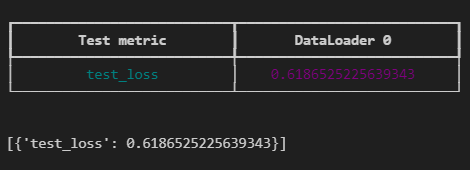

# Decode output

In [30]:
from typing import List
import torch
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.word2index['<blank>']

    def forward(self, emission: torch.Tensor) -> List[str]:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[seq_len, num_label]`.

        Returns:
          List[str]: The resulting transcript
        """
        # your implementation   
        path_indices = torch.argmax(emission, dim=1)
        filtered_path_indices = [path_indices[0].item()]
        for i in range(1, len(path_indices)):
            if path_indices[i] != path_indices[i-1]:
                filtered_path_indices.append(path_indices[i].item())
        filtered_path_indices = [i for i in filtered_path_indices if i != self.blank]
        output_seq_list = [self.vocab.index2word[i] for i in filtered_path_indices] 
        return output_seq_list

In [37]:
model = MathOnlineModel.load_from_checkpoint(r'lightning_logs/lightning_logs/version_0/checkpoints/epoch=9-val_loss=0.6065.ckpt')
model.eval()
model = model.to('cuda')

In [38]:
dataset = CROHME(annotation='crohme2019_valid.txt', root_dir='crohme2019', vocab=Vocab('crohme_vocab.txt'))
features, labels, input_lens, label_lens = dataset.__getitem__(0)
features = features.to('cuda')
greedy_decoder = GreedyCTCDecoder(vocab)
output = model(features)
decoded = greedy_decoder.forward(output.log_softmax(1))
print(decoded)
# possible output if your training work well
# decoded -> ['\\phi', 'Right', '(', 'Right', '0', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']

['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


In [31]:
from torchmetrics.functional.text.helper import _LevenshteinEditDistance 
def edit_distance(pred_seq, label_seq):
    # Your code here
    input_words = pred_seq
    cached_ed = _LevenshteinEditDistance(reference_tokens=label_seq)
    distance, _ = cached_ed(input_words)
    return distance

# Test your implementation
assert edit_distance(['\\phi',
  'Right',
  '(',
  'Right',
  '0',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')'],
 ['\\phi',
  'Right',
  '(',
  'Right',
  '\\phi',
  'Right',
  '(',
  'Right',
  'n',
  'Right',
  ')',
  'Right',
  ')']) == 1
print("Passed")

Passed


In [40]:
import pytorch_lightning as pl
import torch
from torchmetrics.functional.text.helper import _LevenshteinEditDistance 

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers = 3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = GreedyCTCDecoder(vocab)
        
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)

        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        
        # loop: calculate edit distance
        for i in range(x.shape[0]):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            if len(label_seq) == 0:
                continue
            total_edits += edit_distance(pred_seq, label_seq)
            total_lens += len(label_seq)
            
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', total_edits / total_lens, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)
        
        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        
        # loop: calculate edit distance
        for i in range(x.shape[0]):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            if len(label_seq) == 0:
                continue
            total_edits += edit_distance(pred_seq, label_seq) 
            total_lens += len(label_seq)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)
        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        
        # loop: calculate edit distance
        for i in range(x.shape[0]):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            total_edits += edit_distance(pred_seq, label_seq)
            total_lens += len(label_seq)
        
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [36]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

trainer = Trainer(
    # checkpoint_callback=True,
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),
    ], 
    logger = TensorBoardLogger('lightning_logs'),
    check_val_every_n_epoch=1,
    fast_dev_run=False,
    default_root_dir='checkpoint',
    deterministic=False, 
    max_epochs=5, 
    log_every_n_steps=50,
    devices = 1,
)
# model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint(r'lightning_logs/lightning_logs/version_2/checkpoints/epoch=4-val_wer=0.1602.ckpt')
dm = CROHMEDatamodule(root_dir='crohme2019', 
                       train_annotation='crohme2019_train.txt', 
                       validation_annotation='crohme2019_valid.txt', 
                       test_annotation='crohme2019_test.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=32
                       )
        
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 955 K  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | GreedyCTCDecoder            | 0      | train
------------------------------------------------------------------
955 K     Trainable params
0         Non-trainable params
955 K     Total params
3.823     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\trian\anaconda3\envs\DETR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\trian\anaconda3\envs\DETR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:  42%|████▏     | 118/279 [05:52<08:01,  0.33it/s, v_num=4, train_loss_step=0.414, train_wer_step=0.617]

c:\Users\trian\anaconda3\envs\DETR\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [41]:
from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    'lightning_logs/lightning_logs/version_6/checkpoints/epoch=4-val_loss=0.5878.ckpt', 
    decoder=GreedyCTCDecoder(dataset.vocab)
)

# Initialize the data module
dm = CROHMEDatamodule(root_dir='crohme2019', 
                       train_annotation='crohme2019_train.txt', 
                       validation_annotation='crohme2019_valid.txt', 
                       test_annotation='crohme2019_valid.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=1
                       )

# Test the model
try:
    trainer.test(model, datamodule=dm)
except AttributeError:
    print("Model is not implemented correctly")
    pass

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\trian\anaconda3\envs\DETR\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 986/986 [01:03<00:00, 15.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.586701512336731     │
│         test_wer          │    0.1392366886138916     │
└───────────────────────────┴───────────────────────────┘

Here is the output: 

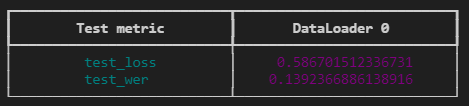

In [42]:
with open('crohme_vocab.txt', 'r') as file:
    items = file.read().splitlines()

symbols = []
relations = []
relation_keywords = {'Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup'}

for item in items:
    if item in relation_keywords or item.startswith("\\") and not item[1:].isalpha():
        relations.append(item)
    else:
        symbols.append(item)

print("Symbols:", symbols)
print(len(symbols))
print("Relations:", relations)
print(len(relations))

Symbols: ['!', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'B', 'C', 'COMMA', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos', '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots', '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']
99
Relations: ['\\{', '\\}', 'Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup']
9


In [43]:
import pytorch_lightning as pl
import torch
from torchmetrics.functional.text.helper import _LevenshteinEditDistance as _LE_distance

class MathOnlineModel(pl.LightningModule):
    def __init__(self, lr=0.001, input_size=4, output_size=109, hidden_size=128, num_layers = 3, decoder=None):
        super().__init__()
        self.model = LSTM_TemporalClassification(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.CTCLoss(blank=output_size - 1)
        self.lr = lr
        self.decoder = decoder
        
    def forward(self, x):
        return self.model(x)
    
    def separate_symbols_relations(self, sequence):
        symbols = []
        relations = []
        relation_keywords = {'Above', 'Below', 'Inside', 'NoRel', 'Right', 'Sub', 'Sup'}
        for item in sequence:
            if item in relation_keywords or item.startswith("\\") and not item[1:].isalpha():
                relations.append(item)
            else:
                symbols.append(item)
        return symbols, relations

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)

        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        total_edits_sym = 0
        total_lens_sym = 0
        total_edits_rel = 0
        total_lens_rel = 0
        # loop: calculate edit distance
        for i in range(len(y)):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            if len(label_seq) == 0:
                continue
            total_edits += edit_distance(pred_seq, label_seq)
            total_lens += len(label_seq)
            label_symbols, label_relations = self.separate_symbols_relations(label_seq)
            pred_symbols, pred_relations = self.separate_symbols_relations(pred_seq)

    
            # Calculate edit distances for symbols and relations separately
            total_edits_sym += edit_distance(pred_symbols, label_symbols)
            total_lens_sym += len(label_symbols)
            total_edits_rel += edit_distance(pred_relations, label_relations)
            total_lens_rel += len(label_relations)
            
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer', total_edits / total_lens, prog_bar=True, on_step=True, on_epoch=True)

        # complete the following metrics
        self.log('train_wer_sym', total_edits_sym / total_lens_sym if total_lens_sym > 0 else 0, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_wer_rel', total_edits_rel / total_lens_rel if total_lens_rel > 0 else 0, prog_bar=True, on_step=True, on_epoch=True)

        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)

        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        total_edits_sym = 0
        total_lens_sym = 0
        total_edits_rel = 0
        total_lens_rel = 0
        # loop: calculate edit distance
        for i in range(len(y)):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            if len(label_seq) == 0:
                continue
            total_edits += edit_distance(pred_seq, label_seq)
            total_lens += len(label_seq)
            label_symbols, label_relations = self.separate_symbols_relations(label_seq)
            pred_symbols, pred_relations = self.separate_symbols_relations(pred_seq)

    
            # Calculate edit distances for symbols and relations separately
            total_edits_sym += edit_distance(pred_symbols, label_symbols)
            total_lens_sym += len(label_symbols)
            total_edits_rel += edit_distance(pred_relations, label_relations)
            total_lens_rel += len(label_relations)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)
    
        
        # complete the following metrics
        self.log('val_wer_sym', total_edits_sym / total_lens_sym if total_lens_sym > 0 else 0, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_wer_rel', total_edits_rel / total_lens_rel if total_lens_rel > 0 else 0, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch
        
        # your code to calculate loss
        y_hat = self.forward(x)
        y_hat_reshaped = y_hat.permute(1, 0, 2)  # Adjusting from [batch, seq_length, num_classes]
        loss = self.criterion(y_hat_reshaped.log_softmax(2), y, x_lens, y_lens)

        # your code to calculate total edit distance
        total_edits = 0
        total_lens = 0
        total_edits_sym = 0
        total_lens_sym = 0
        total_edits_rel = 0
        total_lens_rel = 0
        # loop: calculate edit distance
        for i in range(len(y)):
            label = y[i].tolist()
            label_seq = [vocab.index2word[index] for index in label]
            pred_seq = self.decoder.forward(y_hat[i].log_softmax(1))
            if len(label_seq) == 0:
                continue
            total_edits += edit_distance(pred_seq, label_seq)
            total_lens += len(label_seq)
            label_symbols, label_relations = self.separate_symbols_relations(label_seq)
            pred_symbols, pred_relations = self.separate_symbols_relations(pred_seq)

    
            # Calculate edit distances for symbols and relations separately
            total_edits_sym += edit_distance(pred_symbols, label_symbols)
            total_lens_sym += len(label_symbols)
            total_edits_rel += edit_distance(pred_relations, label_relations)
            total_lens_rel += len(label_relations)
        
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer', total_edits / total_lens, prog_bar=True, on_step=False, on_epoch=True)

        # complete the following metrics
        self.log('test_wer_sym', total_edits_sym / total_lens_sym if total_lens_sym > 0 else 0, prog_bar=True, on_step=False, on_epoch=True)
        self.log('test_wer_rel', total_edits_rel / total_lens_rel if total_lens_rel > 0 else 0, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [44]:
from pytorch_lightning import Trainer

trainer = Trainer(
    devices = 1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    'lightning_logs/lightning_logs/version_6/checkpoints/epoch=4-val_loss=0.5878.ckpt', 
    decoder=GreedyCTCDecoder(dataset.vocab)
)

# Initialize the data module
dm = CROHMEDatamodule(root_dir='crohme2019', 
                       train_annotation='crohme2019_train.txt', 
                       validation_annotation='crohme2019_valid.txt', 
                       test_annotation='crohme2019_valid.txt', 
                       vocab_file='crohme_vocab.txt', 
                       batch_size=1
                       )

# Test the model
try:
    trainer.test(model, datamodule=dm)
except AttributeError:
    print("Model is not implemented correctly")
    pass

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 986/986 [01:09<00:00, 14.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.586701512336731     │
│         test_wer          │    0.1392366886138916     │
│       test_wer_rel        │    0.1177755668759346     │
│       test_wer_sym        │    0.15408888459205627    │
└───────────────────────────┴───────────────────────────┘

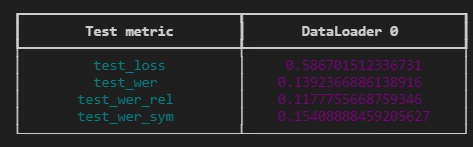